In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score
from scipy.stats import shapiro, ttest_rel, mannwhitneyu

In [145]:
serie = pd.read_csv("serie_tiempo.csv", parse_dates=["fecha"], index_col="fecha")

In [146]:
umbral = serie["consumo"].quantile(0.90)
y = (serie["consumo"] > umbral).astype(int)

X = pd.DataFrame({"consumo": serie["consumo"]})
X["lag1"] = serie["consumo"].shift(1)
X["lag2"] = serie["consumo"].shift(2)
X["rolling_mean3"] = serie["consumo"].rolling(3).mean()
X["rolling_std3"] = serie["consumo"].rolling(3).std()
X["hour"] = X.index.hour

X = X.dropna()
y = y.loc[X.index]

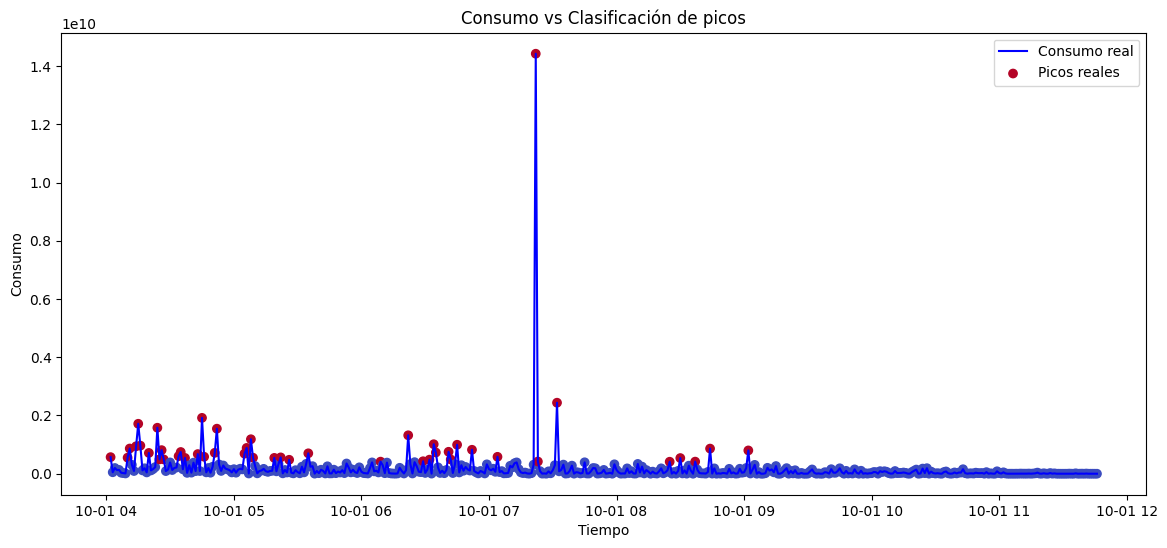

In [147]:
plt.figure(figsize=(14,6))
plt.plot(X["consumo"], label="Consumo real", color="blue")
plt.scatter(X.index, X["consumo"], c=y, cmap="coolwarm", label="Picos reales", marker="o")
plt.title("Consumo vs Clasificación de picos")
plt.xlabel("Tiempo")
plt.ylabel("Consumo")
plt.legend()
plt.show()

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

In [149]:
skf = StratifiedKFold(n_splits=30, shuffle=True, random_state=42)

In [150]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
scores_rf = cross_val_score(rf, X_train, y_train, cv=skf, scoring="accuracy")
rf_mean, rf_std = scores_rf.mean(), scores_rf.std()
print("Random Forest accuracy promedio:", rf_mean, "±", rf_std)

Random Forest accuracy promedio: 1.0 ± 0.0


In [151]:
logreg = LogisticRegression(max_iter=1000)
scores_lr = cross_val_score(logreg, X_train, y_train, cv=skf, scoring="accuracy")
lr_mean, lr_std = scores_lr.mean(), scores_lr.std()
print("Logistic Regression accuracy promedio:", lr_mean, "±", lr_std)

Logistic Regression accuracy promedio: 0.7514814814814816 ± 0.14050125823824317


In [152]:
shapiro_rf = shapiro(scores_rf)

print(f"\nShapiro-Wilk RF p-value: {shapiro_rf.pvalue:.3f}")


Shapiro-Wilk RF p-value: 1.000


c:\Users\Claudia\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:592: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [153]:
shapiro_lr = shapiro(scores_lr)

print(f"Shapiro-Wilk LR p-value: {shapiro_lr.pvalue:.3f}")

Shapiro-Wilk LR p-value: 0.108


In [154]:
if shapiro_rf.pvalue > 0.05 and shapiro_lr.pvalue > 0.05:
    stat, pval = ttest_rel(scores_rf, scores_lr)
    print(f"\nt-Student: statistic={stat:.3f}, p-value={pval:.3f}")
else:
    stat, pval = mannwhitneyu(scores_rf, scores_lr)
    print(f"\nMann-Whitney: statistic={stat:.3f}, p-value={pval:.3f}")


t-Student: statistic=9.525, p-value=0.000


In [155]:
if pval < 0.05:  # diferencia significativa
    best_model = rf if rf_mean > lr_mean else logreg
    best_name = "Random Forest" if rf_mean > lr_mean else "Logistic Regression"
else:
    # si no hay diferencia significativa, escoger el más simple (Logistic Regression)
    best_model = logreg
    best_name = "Logistic Regression"

print(f"\nModelo seleccionado: {best_name}")


Modelo seleccionado: Random Forest


In [156]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
test_error = 1 - test_acc

print(f"Accuracy en test: {test_acc:.3f}")
print(f"Error en test: {test_error:.3f}")

Accuracy en test: 1.000
Error en test: 0.000


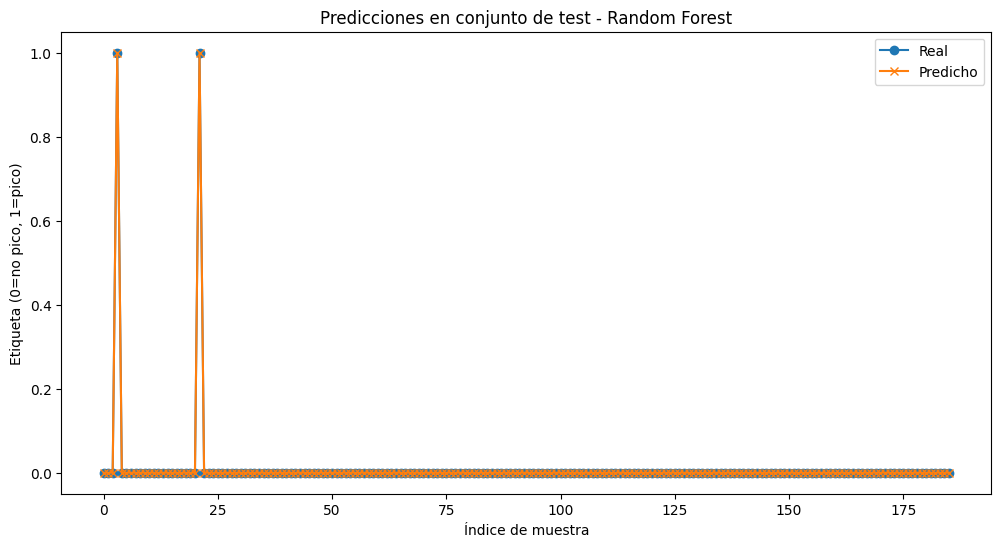

In [157]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Real", marker="o")
plt.plot(y_pred, label="Predicho", marker="x")
plt.title(f"Predicciones en conjunto de test - {best_name}")
plt.xlabel("Índice de muestra")
plt.ylabel("Etiqueta (0=no pico, 1=pico)")
plt.legend()
plt.show()

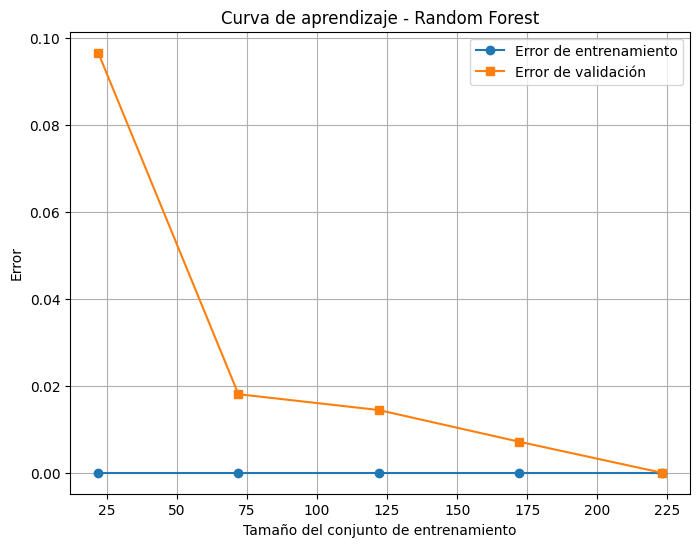

In [158]:
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train,
    cv=5,
    scoring="accuracy",
    shuffle=False,
    random_state=42
)

train_error = 1 - train_scores.mean(axis=1)
val_error = 1 - val_scores.mean(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_error, label="Error de entrenamiento", marker="o")
plt.plot(train_sizes, val_error, label="Error de validación", marker="s")
plt.title(f"Curva de aprendizaje - {best_name}")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()

La curva de aprendizaje muestra que Random Forest mantiene un error de entrenamiento bajo y estable, mientras que el error de validación disminuye rápidamente y se estabiliza, lo que indica buena capacidad de generalización y ausencia de sobreajuste.